In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

## 2D meshing example

This notebook shows how to mesh a 2D image:

1. Load and visualize a volume
2. Select a plane from a volume
3. Apply image filters and segment an image
4. Generate a 2D mesh from the binary image
5. Visualize and save the mesh to gmsh22 format

In [2]:
from nanomesh.volume import Volume
from nanomesh.plane import Plane
import pyvista as pv
from skimage import filters
import numpy as np

In [3]:
vol = Volume.load('sample_data.npy')
# vol.image = vol.image[:, 0:150]

In [4]:
# vol.show_volume()

In [5]:
# vol.show_slice()

In [6]:
plane = vol.select_plane(x=161)

In [7]:
# plane.show()

<IPython.core.display.Javascript object>


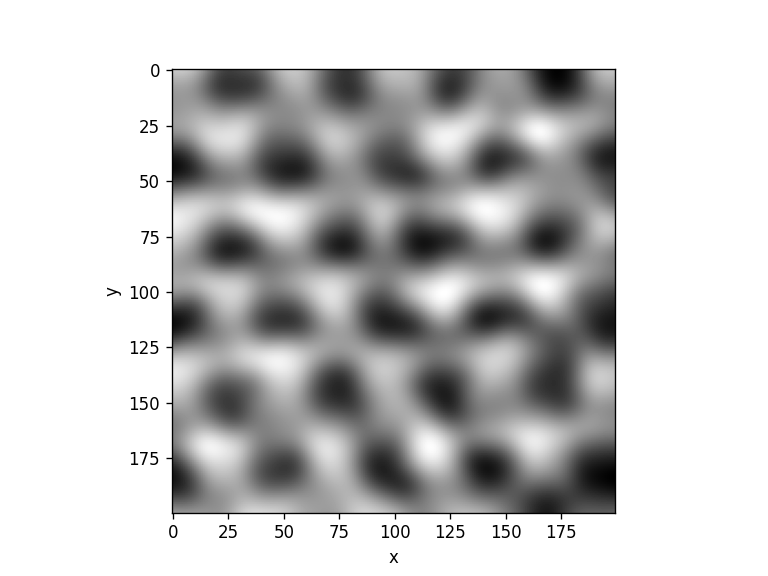

<AxesSubplot:xlabel='x', ylabel='y'>

In [8]:
plane_gauss = plane.apply(filters.gaussian, sigma=5)
plane_gauss.show()

<IPython.core.display.Javascript object>


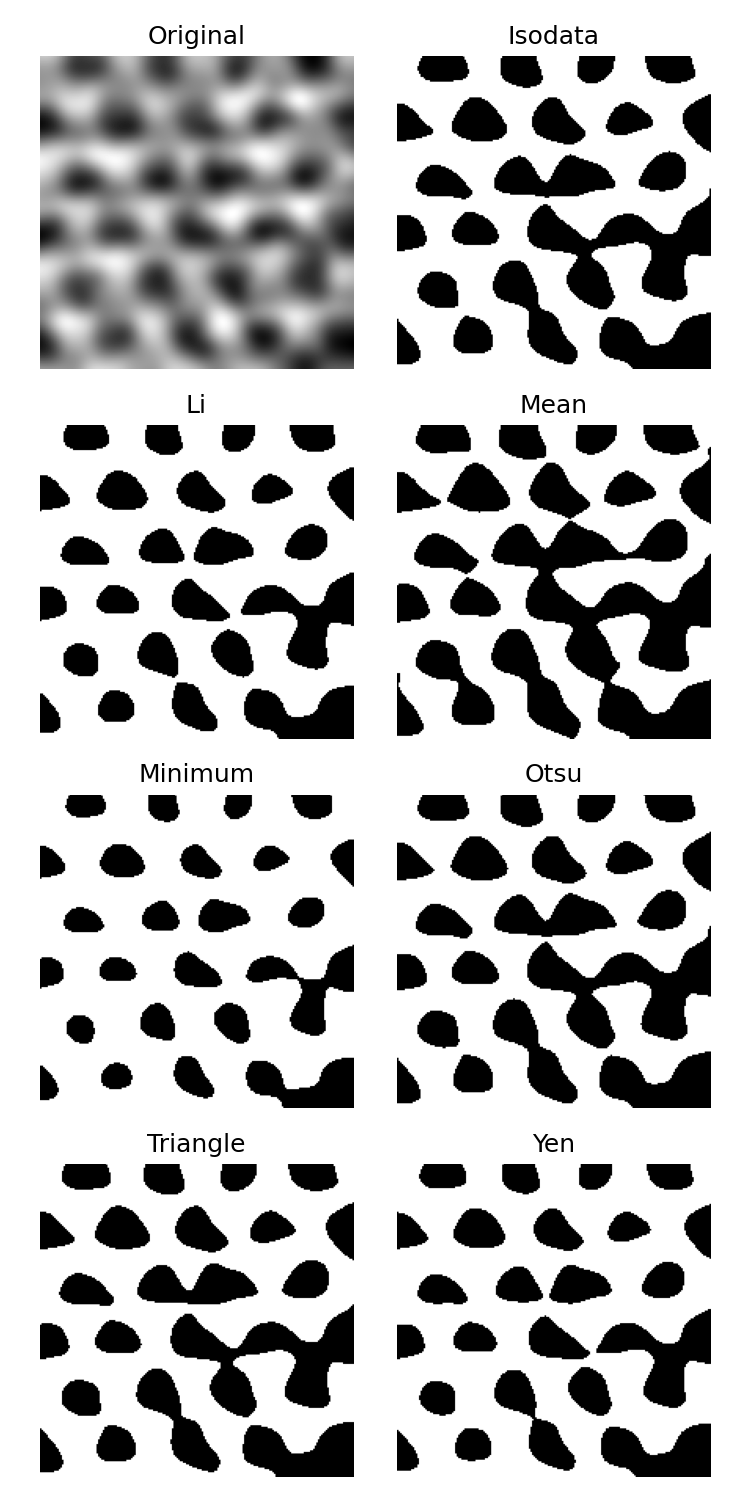

In [9]:
filters.try_all_threshold(plane_gauss.image, figsize=(5, 10), verbose=False);

In [10]:
thresh = filters.threshold_li(plane_gauss.image)

<IPython.core.display.Javascript object>


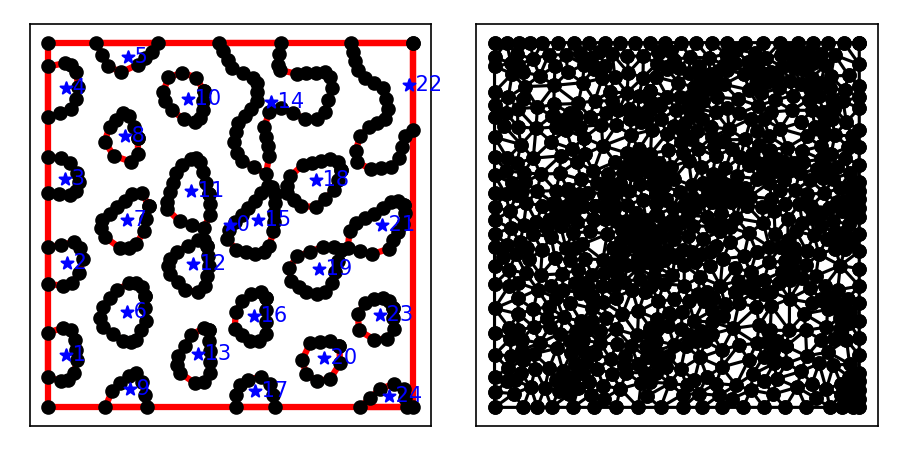

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [53]:
from nanomesh.mesh2d import Mesher2D

mesher = Mesher2D(plane_gauss.image)
mesher.generate_contours(label=1, max_contour_dist = 5, level=thresh)

vmesh = mesher.triangulate(label=1, opts='q30a100', plot=True)

vmesh.plot_itk()

Save the output...

In [30]:
vmesh.write('out.msh', format='gmsh22', binary=False)